# Association Rules

# Case 1: Using id

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import col, explode, count, when, isnull


In [2]:
spark = SparkSession.builder \
    .appName("AssociationRules") \
    .getOrCreate()

25/01/27 12:21:33 WARN Utils: Your hostname, Adams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.10 instead (on interface en0)
25/01/27 12:21:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 12:21:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/27 12:21:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/27 12:21:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
bakery_data = spark.read.csv(
    "/Users/ssyan110/Codes/Big_data_in_machine_learning/Final/Data/75000/75000-out1.csv",
    header=False,
    inferSchema=True
)
bakery_data.show(5)
bakery_data.printSchema()

+---+----+----+
|_c0| _c1| _c2|
+---+----+----+
|  1|11.0|21.0|
|  2| 7.0|11.0|
|  3| 3.0|33.0|
|  4| 5.0|12.0|
|  5| 6.0|18.0|
+---+----+----+
only showing top 5 rows

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)



In [4]:
# Name the columns
bakery_data = bakery_data.toDF("TransactionID", "ItemID1", "ItemID2")
bakery_data.show(5)
bakery_data.printSchema()

+-------------+-------+-------+
|TransactionID|ItemID1|ItemID2|
+-------------+-------+-------+
|            1|   11.0|   21.0|
|            2|    7.0|   11.0|
|            3|    3.0|   33.0|
|            4|    5.0|   12.0|
|            5|    6.0|   18.0|
+-------------+-------+-------+
only showing top 5 rows

root
 |-- TransactionID: integer (nullable = true)
 |-- ItemID1: double (nullable = true)
 |-- ItemID2: double (nullable = true)



## Preprocessing

In [5]:
# check for missing data
bakery_data.select([count(when(isnull(c), c)).alias(c) for c in bakery_data.columns]).show()

+-------------+-------+-------+
|TransactionID|ItemID1|ItemID2|
+-------------+-------+-------+
|            0|      0|   3592|
+-------------+-------+-------+



In [6]:
valid_data = bakery_data.filter(bakery_data["ItemID2"].isNotNull())
valid_data.show(5)

+-------------+-------+-------+
|TransactionID|ItemID1|ItemID2|
+-------------+-------+-------+
|            1|   11.0|   21.0|
|            2|    7.0|   11.0|
|            3|    3.0|   33.0|
|            4|    5.0|   12.0|
|            5|    6.0|   18.0|
+-------------+-------+-------+
only showing top 5 rows



## EDA

In [7]:
bakery_data.describe().show()

+-------+-----------------+------------------+------------------+
|summary|    TransactionID|           ItemID1|           ItemID2|
+-------+-----------------+------------------+------------------+
|  count|            75000|             75000|             71408|
|   mean|          37500.5|10.907106666666667|21.120266636791396|
| stddev|21650.77943169714| 9.988473077663798|  11.6884778948076|
|    min|                1|               0.0|               1.0|
|    max|            75000|              49.0|              49.0|
+-------+-----------------+------------------+------------------+



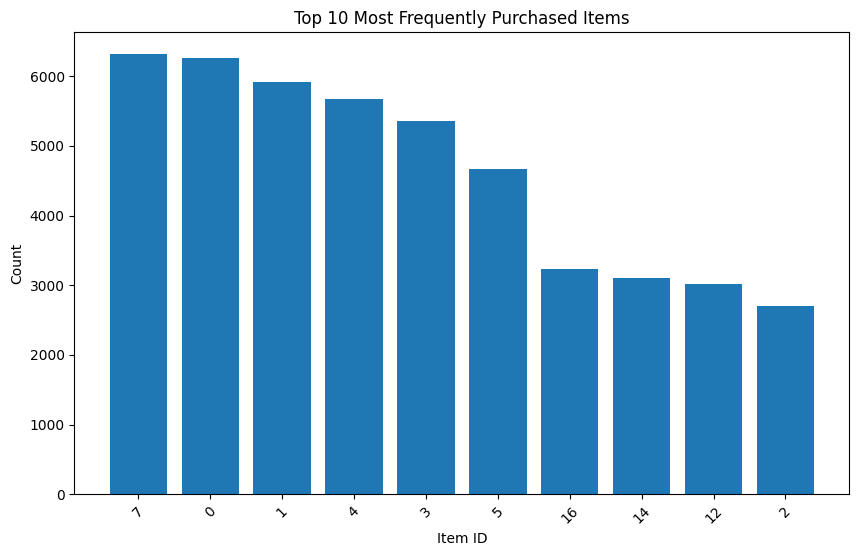

In [8]:
import matplotlib.pyplot as plt

# Count occurrences of each item
item_counts = bakery_data.groupBy("ItemID1").agg(count("*").alias("Count"))
top_items = item_counts.orderBy("Count", ascending=False).limit(10)


top_items_pd = top_items.toPandas()
top_items_pd["ItemID1"] = top_items_pd["ItemID1"].astype(int).astype(str)

# Plot again with cleaned labels
plt.figure(figsize=(10, 6))
plt.bar(top_items_pd["ItemID1"], top_items_pd["Count"])
plt.title("Top 10 Most Frequently Purchased Items")
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

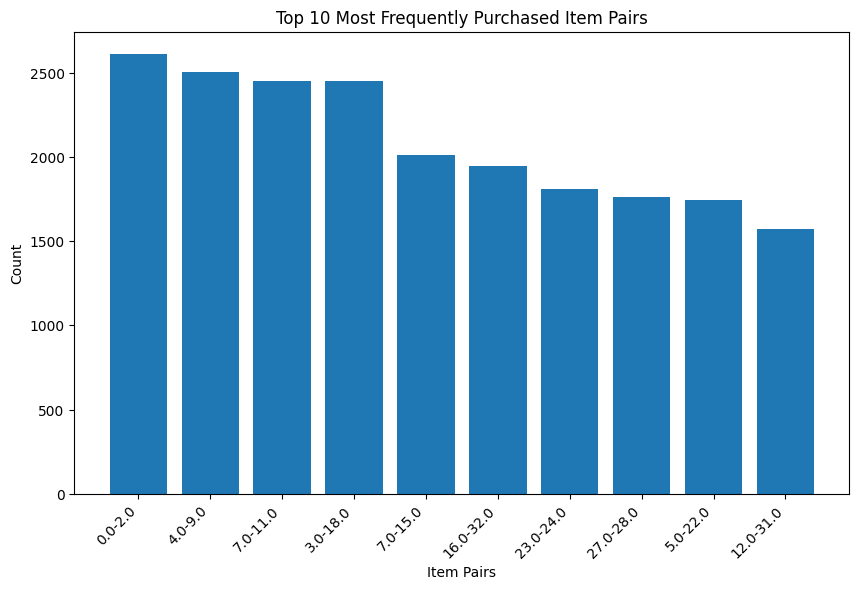

In [9]:
from pyspark.sql.functions import array, explode, col, count

# Combine ItemID1 and ItemID2 into an array column
bakery_data = bakery_data.withColumn("Items", array("ItemID1", "ItemID2"))

# Explode the array into individual rows
exploded_data = bakery_data.select("TransactionID", explode(col("Items")).alias("Item"))

# Count occurrences of each item pair (after exploding)
pair_counts = exploded_data.alias("a") \
    .join(exploded_data.alias("b"), col("a.TransactionID") == col("b.TransactionID")) \
    .filter(col("a.Item") < col("b.Item")) \
    .groupBy("a.Item", "b.Item") \
    .agg(count("*").alias("PairCount"))

# Get the top 10 most common pairs
top_pairs = pair_counts.orderBy("PairCount", ascending=False).limit(10)

# Convert to Pandas for visualization
top_pairs_pd = top_pairs.toPandas()

# Ensure correct referencing of DataFrame columns
top_pairs_pd.columns = ["Item1", "Item2", "PairCount"]  # Renaming columns for clarity

# Plot the top 10 item pairs
plt.figure(figsize=(10, 6))
plt.bar(
    [f"{row['Item1']}-{row['Item2']}" for _, row in top_pairs_pd.iterrows()],
    top_pairs_pd["PairCount"]
)
plt.title("Top 10 Most Frequently Purchased Item Pairs")
plt.xlabel("Item Pairs")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

### Top 10 Most Frequently Purchased Item Pairs
- The bar chart shows the most commonly purchased item pairs, such as "0-2", "4-9", and "7-11".
- **Actionable Insights**:
  - These combinations suggest items that frequently co-occur in transactions.
  - Promote these pairs through discounts, bundle offers, or co-location on shelves to increase sales.

## Generate frequent itemsets

In [10]:
from pyspark.ml.fpm import FPGrowth

fp_data = bakery_data.select("TransactionID", "Items").distinct()

fp_growth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.1)
model = fp_growth.fit(fp_data)

print("Frequent Itemsets:")
frequent_itemsets = model.freqItemsets
frequent_itemsets.show(10, truncate=False)


Frequent Itemsets:
+------------+----+
|items       |freq|
+------------+----+
|[32.0]      |2983|
|[32.0, 16.0]|1950|
|[21.0]      |1771|
|[NULL]      |3592|
|[9.0]       |5124|
|[9.0, 4.0]  |2504|
|[44.0]      |1331|
|[44.0, 14.0]|864 |
|[10.0]      |2616|
|[11.0]      |4955|
+------------+----+
only showing top 10 rows



In [11]:
association_rules = model.associationRules
association_rules.show(10, truncate=False)

+----------+----------+-------------------+------------------+--------------------+
|antecedent|consequent|confidence         |lift              |support             |
+----------+----------+-------------------+------------------+--------------------+
|[19.0]    |[1.0]     |0.4651851851851852 |5.563528765569908 |0.020933333333333335|
|[14.0]    |[44.0]    |0.1648854961832061 |9.291068530233252 |0.01152             |
|[12.0]    |[31.0]    |0.3579713440982488 |10.430400469063192|0.020986666666666667|
|[17.0]    |[29.0]    |0.3320222119389172 |9.799947223698855 |0.019133333333333332|
|[16.0]    |[32.0]    |0.3890662410215483 |9.782087856726825 |0.026               |
|[15.0]    |[7.0]     |0.4837935174069628 |4.619288835839874 |0.026866666666666667|
|[33.0]    |[42.0]    |0.3631142310146777 |13.664609797341107|0.015173333333333334|
|[4.0]     |[9.0]     |0.36823529411764705|5.389860862377738 |0.03338666666666667 |
|[9.0]     |[4.0]     |0.4886807181889149 |5.389860862377738 |0.033386666666

## Check timesets

In [12]:
frequent_itemsets.orderBy("freq", ascending=False).show(10, truncate=False)

+------+----+
|items |freq|
+------+----+
|[7.0] |7855|
|[4.0] |6800|
|[1.0] |6271|
|[0.0] |6265|
|[3.0] |6076|
|[5.0] |5971|
|[2.0] |5574|
|[14.0]|5240|
|[9.0] |5124|
|[18.0]|5047|
+------+----+
only showing top 10 rows



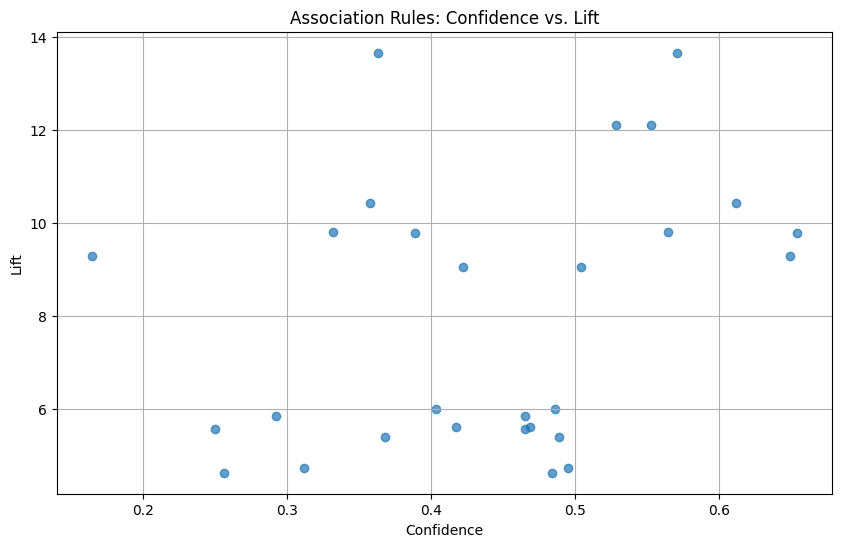

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert rules to Pandas for visualization
rules_pd = association_rules.toPandas()

# Plot confidence vs. lift
plt.figure(figsize=(10, 6))
plt.scatter(rules_pd["confidence"], rules_pd["lift"], alpha=0.7)
plt.title("Association Rules: Confidence vs. Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)
plt.show()

### Confidence vs. Lift Scatterplot
- The scatterplot highlights the relationship between **confidence** and **lift** for association rules.
- Rules with high **confidence** (e.g., `[Raspberry Lemonade] → [Lemon Cookie]`) and high **lift** indicate strong dependencies.
- **Actionable Insights**:
  - High-lift rules (e.g., lift > 10) suggest products that have strong cross-sell potential.
  - Target these rules in marketing campaigns or email recommendations.


# Case 2: Including flavor and food name

In [14]:
transactions = spark.read.csv("/Users/ssyan110/Codes/Big_data_in_machine_learning/Final/Data/75000/75000i.csv", header=False, inferSchema=True)
transactions = transactions.toDF("TransactionID", "Quantity", "ItemID")

goods = spark.read.csv("/Users/ssyan110/Codes/Big_data_in_machine_learning/Final/Data/75000/goods.csv", header=True, inferSchema=True)

In [15]:
transactions.show()

+-------------+--------+------+
|TransactionID|Quantity|ItemID|
+-------------+--------+------+
|            1|       1|    21|
|            1|       5|    11|
|            2|       1|     7|
|            2|       3|    11|
|            2|       4|    37|
|            2|       3|    45|
|            3|       5|     3|
|            3|       3|    42|
|            3|       3|    33|
|            4|       1|     5|
|            4|       2|    12|
|            4|       1|    47|
|            4|       4|    17|
|            5|       2|    42|
|            5|       5|     6|
|            5|       3|    18|
|            6|       4|     2|
|            6|       3|     4|
|            6|       4|    34|
|            7|       1|    15|
+-------------+--------+------+
only showing top 20 rows



In [16]:
goods.show()

+---+------------+--------+-----+------+
| Id|      Flavor|    Food|Price|  Type|
+---+------------+--------+-----+------+
|  0| 'Chocolate'|  'Cake'| 8.95|'Food'|
|  1|     'Lemon'|  'Cake'| 8.95|'Food'|
|  2|    'Casino'|  'Cake'|15.95|'Food'|
|  3|     'Opera'|  'Cake'|15.95|'Food'|
|  4|'Strawberry'|  'Cake'|11.95|'Food'|
|  5|   'Truffle'|  'Cake'|15.95|'Food'|
|  6| 'Chocolate'|'Eclair'| 3.25|'Food'|
|  7|    'Coffee'|'Eclair'|  3.5|'Food'|
|  8|   'Vanilla'|'Eclair'| 3.25|'Food'|
|  9|  'Napoleon'|  'Cake'|13.49|'Food'|
| 10|    'Almond'|  'Tart'| 3.75|'Food'|
| 11|     'Apple'|   'Pie'| 5.25|'Food'|
| 12|     'Apple'|  'Tart'| 3.25|'Food'|
| 13|   'Apricot'|  'Tart'| 3.25|'Food'|
| 14|     'Berry'|  'Tart'| 3.25|'Food'|
| 15|'Blackberry'|  'Tart'| 3.25|'Food'|
| 16| 'Blueberry'|  'Tart'| 3.25|'Food'|
| 17| 'Chocolate'|  'Tart'| 3.75|'Food'|
| 18|    'Cherry'|  'Tart'| 3.25|'Food'|
| 19|     'Lemon'|  'Tart'| 3.25|'Food'|
+---+------------+--------+-----+------+
only showing top

In [17]:
# Join transactions with goods on ItemID
joined_data = transactions.join(goods, transactions["ItemID"] == goods["Id"], how="inner")

# Select necessary columns
joined_data = joined_data.select("TransactionID", "Quantity", "ItemID", "Flavor", "Food")

# Display the result
joined_data.show(5, truncate=False)

+-------------+--------+------+---------+--------+
|TransactionID|Quantity|ItemID|Flavor   |Food    |
+-------------+--------+------+---------+--------+
|1            |1       |21    |'Ganache'|'Cookie'|
|1            |5       |11    |'Apple'  |'Pie'   |
|2            |1       |7     |'Coffee' |'Eclair'|
|2            |3       |11    |'Apple'  |'Pie'   |
|2            |4       |37    |'Almond' |'Twist' |
+-------------+--------+------+---------+--------+
only showing top 5 rows



In [18]:
# Creating Item Descriptions together

from pyspark.sql.functions import concat_ws

# Combine Flavor and Food into a single column
joined_data = joined_data.withColumn("ItemDescription", concat_ws(" ", joined_data["Flavor"], joined_data["Food"]))

# Select only the necessary columns for the next steps
joined_data = joined_data.select("TransactionID", "ItemDescription")

# Display the result
joined_data.show(5, truncate=False)

+-------------+------------------+
|TransactionID|ItemDescription   |
+-------------+------------------+
|1            |'Ganache' 'Cookie'|
|1            |'Apple' 'Pie'     |
|2            |'Coffee' 'Eclair' |
|2            |'Apple' 'Pie'     |
|2            |'Almond' 'Twist'  |
+-------------+------------------+
only showing top 5 rows



In [19]:
from pyspark.sql.functions import collect_list

# Group items by TransactionID
grouped_data = joined_data.groupBy("TransactionID") \
    .agg(collect_list("ItemDescription").alias("Items"))

# Display the grouped data
grouped_data.show(5, truncate=False)

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|TransactionID|Items                                                                                                                                                   |
+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|1            |['Ganache' 'Cookie', 'Apple' 'Pie']                                                                                                                     |
|12           |['Casino' 'Cake', 'Opera' 'Cake', 'Raspberry' 'Lemonade', 'Ganache' 'Cookie', 'Apple' 'Pie', 'Almond' 'Twist', 'Single' 'Espresso']                     |
|13           |['Green' 'Tea', 'Chocolate' 'Tart', 'Cherry' 'Soda', 'Opera' 'Cake']                                                                        

In [20]:
fp_growth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.1)
model_2 = fp_growth.fit(grouped_data)

print("Frequent Itemsets:")
model_2.freqItemsets.show(10, truncate=False)

Frequent Itemsets:


+--------------------------------------------------------------+----+
|items                                                         |freq|
+--------------------------------------------------------------+----+
|['Raspberry' 'Lemonade']                                      |5081|
|['Raspberry' 'Lemonade', 'Lemon' 'Cookie']                    |2087|
|['Raspberry' 'Lemonade', 'Lemon' 'Cookie', 'Lemon' 'Lemonade']|1922|
|['Raspberry' 'Lemonade', 'Lemon' 'Lemonade']                  |2088|
|['Almond' 'Bear Claw']                                        |3183|
|['Marzipan' 'Cookie']                                         |6733|
|['Marzipan' 'Cookie', 'Tuile' 'Cookie']                       |3819|
|['Almond' 'Twist']                                            |5790|
|['Almond' 'Twist', 'Hot' 'Coffee']                            |2319|
|['Almond' 'Twist', 'Hot' 'Coffee', 'Coffee' 'Eclair']         |2109|
+--------------------------------------------------------------+----+
only showing top 10 

### Frequent Itemsets
- Top frequent itemsets include pairs like `["Coffee", "Eclair"]`, `["Hot Coffee"]`, and `["Marzipan Cookie"]`.
- **Actionable Insights**:
  - Maintain high stock levels for these combinations to meet customer demand.
  - Use popular itemsets as anchors in marketing campaigns (e.g., advertise "Coffee & Eclair mornings").

In [21]:
print("Association Rules:")
model_2.associationRules.show(10, truncate=False)

Association Rules:


+-------------------------------------------------+------------------------+------------------+------------------+--------------------+
|antecedent                                       |consequent              |confidence        |lift              |support             |
+-------------------------------------------------+------------------------+------------------+------------------+--------------------+
|['Raspberry' 'Cookie', 'Lemon' 'Cookie']         |['Green' 'Tea']         |0.7465261140392908|11.95079158013806 |0.020773333333333335|
|['Raspberry' 'Cookie', 'Lemon' 'Cookie']         |['Raspberry' 'Lemonade']|0.9228557738380451|13.622157653582638|0.02568             |
|['Raspberry' 'Cookie', 'Lemon' 'Cookie']         |['Lemon' 'Lemonade']    |0.9257307139434595|13.565807648643897|0.02576             |
|['Apple' 'Pie', 'Almond' 'Twist', 'Hot' 'Coffee']|['Coffee' 'Eclair']     |0.9952471482889734|9.110647640873063 |0.02792             |
|['Blueberry' 'Tart']                           

### Association Rules
- Association rules like `[Green Tea] → [Raspberry Lemonade]` (lift = 13.3, confidence = 91%) show strong relationships.
- **Actionable Insights**:
  - Cross-promote related items at checkout (e.g., offer discounts on Raspberry Lemonade with Green Tea purchases).
  - Optimize product placement to encourage impulse purchases based on rules.


In [22]:
print("Predictions:")
model_2.transform(grouped_data).show(5, truncate=False)

Predictions:
+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TransactionID|Items                                                                                                                                                   |prediction                                                                                                                                                                                                                  |
+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------

In [23]:
goods.filter((goods["Flavor"].like("%Cookie%")) | (goods["Food"].like("%Cookie%"))).show()

+---+-----------+--------+-----+------+
| Id|     Flavor|    Food|Price|  Type|
+---+-----------+--------+-----+------+
| 21|  'Ganache'|'Cookie'| 1.15|'Food'|
| 22|'Gongolais'|'Cookie'| 1.15|'Food'|
| 23|'Raspberry'|'Cookie'| 1.09|'Food'|
| 24|    'Lemon'|'Cookie'| 0.79|'Food'|
| 27| 'Marzipan'|'Cookie'| 1.25|'Food'|
| 28|    'Tuile'|'Cookie'| 1.25|'Food'|
| 29|   'Walnut'|'Cookie'| 0.79|'Food'|
+---+-----------+--------+-----+------+



## Check frequent itemsets

In [24]:
model_2.freqItemsets.orderBy("freq", ascending=False).show(10, truncate=False)

+----------------------+----+
|items                 |freq|
+----------------------+----+
|['Coffee' 'Eclair']   |8193|
|['Hot' 'Coffee']      |7700|
|['Tuile' 'Cookie']    |7556|
|['Cherry' 'Tart']     |6987|
|['Strawberry' 'Cake'] |6948|
|['Apricot' 'Danish']  |6943|
|['Orange' 'Juice']    |6871|
|['Gongolais' 'Cookie']|6783|
|['Marzipan' 'Cookie'] |6733|
|['Berry' 'Tart']      |6362|
+----------------------+----+
only showing top 10 rows



In [25]:
# Sort association rules by confidence in descending order
model_2.associationRules.orderBy("confidence", ascending=False).show(10, truncate=False)

+---------------------------------------------------------------------------------+------------------------+------------------+------------------+--------------------+
|antecedent                                                                       |consequent              |confidence        |lift              |support             |
+---------------------------------------------------------------------------------+------------------------+------------------+------------------+--------------------+
|['Green' 'Tea', 'Raspberry' 'Cookie', 'Raspberry' 'Lemonade', 'Lemon' 'Cookie']  |['Lemon' 'Lemonade']    |1.0               |14.654161781946074|0.020733333333333333|
|['Green' 'Tea', 'Raspberry' 'Lemonade', 'Lemon' 'Cookie', 'Lemon' 'Lemonade']    |['Raspberry' 'Cookie']  |1.0               |14.78415138971023 |0.020733333333333333|
|['Green' 'Tea', 'Raspberry' 'Cookie', 'Lemon' 'Cookie', 'Lemon' 'Lemonade']      |['Raspberry' 'Lemonade']|1.0               |14.760873843731549|0.020733333333

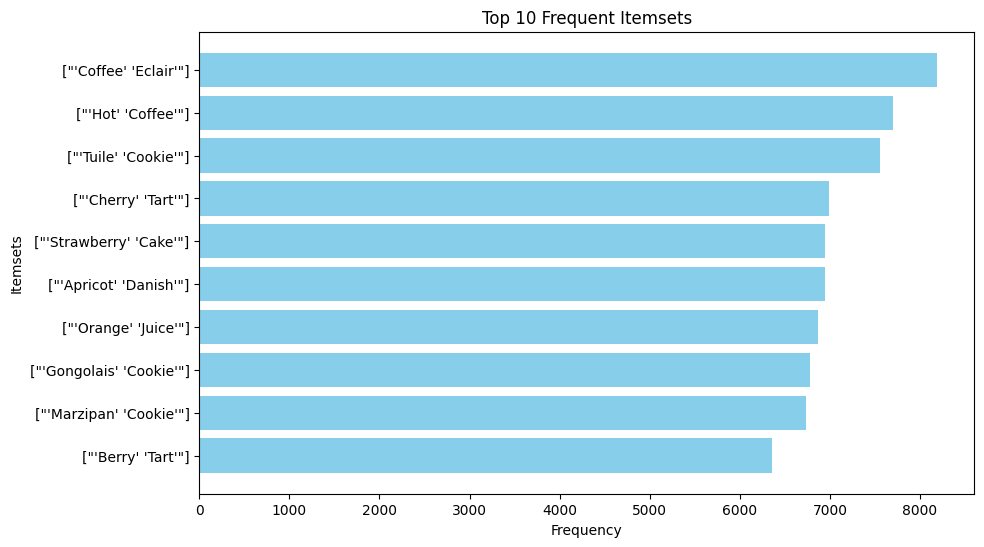

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert frequent itemsets to Pandas
frequent_itemsets_pd = model_2.freqItemsets.toPandas()

# Plot top 10 frequent itemsets
frequent_itemsets_pd = frequent_itemsets_pd.nlargest(10, "freq")
plt.figure(figsize=(10, 6))
plt.barh(frequent_itemsets_pd["items"].astype(str), frequent_itemsets_pd["freq"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

## Marketing and Operational Strategy
- **Marketing**: Use frequent itemsets and rules to create combo deals like "Buy Raspberry Lemonade and get Lemon Cookies at 20% off."
- **Inventory**: Prioritize stock for popular combinations like `["Coffee", "Eclair"]`.
- **Store Layout**: Place strongly associated items (e.g., `["Green Tea"]` and `["Raspberry Lemonade"]`) in proximity to encourage upselling.